# Finetuning of ResNet for COVIDx

In [20]:
from torch.utils.data import Dataset, DataLoader


import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms, utils

import matplotlib.pyplot as plt
import time
import os
import copy

import covidx

print("Torch version: ", torch.__version__)
print("Torchvision version: ", torchvision.__version__)
print(covidx.id2class)

Torch version:  1.4.0
Torchvision version:  0.5.0
{0: 'normal', 1: 'pneumonia', 2: 'COVID-19'}


In [21]:
# I will use the COVIDx dataset

model_name = 'resnet'

batch_size = 4
num_epochs = 1
feature_extract = True

#TODO: get automatically these parameters
num_classes = 3


In [22]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs = 25, is_inception= False):
    since = time.time()
    
    val_acc_history = []
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs -1))
        
        #Each epoch as a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0
            
            # Iterate over data
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                #zero the parameter gradients
                optimizer.zero_grad()
                
                #forward
                # track history
                with torch.set_grad_enabled(phase == 'train'):
                    
                    if is_inception and phase == 'train':
                        outputs, aux_outputs = model(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4*loss2
                        
                    else:
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)
                        
                    _, preds = torch.max(outputs, 1)
                    
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                #statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                
            epoch_loss = running_loss /len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)
            
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            
            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)
            
        print()
        
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:.4f}'.format(best_acc))
    
    #load the best model
    model.load_state_dict(best_model_wts)
    return model, val_acc_history

In [23]:
# set model parameters
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False


In [24]:
# Initialize and reshape the networks

def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    model_ft = None
    input_size = 0

    if model_name == "resnet":
        """ Resnet18
        """
        model_ft = models.resnet18(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "alexnet":
        """ Alexnet
        """
        model_ft = models.alexnet(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "vgg":
        """ VGG11_bn
        """
        model_ft = models.vgg11_bn(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "squeezenet":
        """ Squeezenet
        """
        model_ft = models.squeezenet1_0(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        model_ft.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))
        model_ft.num_classes = num_classes
        input_size = 224

    elif model_name == "densenet":
        """ Densenet
        """
        model_ft = models.densenet121(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier.in_features
        model_ft.classifier = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "inception":
        """ Inception v3
        Be careful, expects (299,299) sized images and has auxiliary output
        """
        model_ft = models.inception_v3(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        # Handle the auxilary net
        num_ftrs = model_ft.AuxLogits.fc.in_features
        model_ft.AuxLogits.fc = nn.Linear(num_ftrs, num_classes)
        # Handle the primary net
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs,num_classes)
        input_size = 299

    else:
        print("Invalid model name, exiting...")
        exit()

    return model_ft, input_size

# Initialize the model for this run
model_ft, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)

# Print the model we just instantiated
print(model_ft)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [25]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(input_size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [26]:
# Load Data

# configure paths to the description txt file and the images folder
train_txt_file = '../COVID-Net/train_split_v2.txt'
train_images_path = '../covid-chestxray-dataset/data/train'

test_txt_file = '../COVID-Net/test_split_v2.txt'
test_images_path = '../covid-chestxray-dataset/data/test'

#train_dataset = covidx.COVIDxDataset(train_txt_file, train_images_path)
#test_dataset = covidx.COVIDxDataset(val_txt_file, val_images_path)

print("Initializing Datasets and Dataloaders...")

# Create training and validation datasets
image_datasets = {'train': covidx.COVIDxDataset(train_txt_file, train_images_path, data_transforms['train']), 'val': covidx.COVIDxDataset(test_txt_file, test_images_path, data_transforms['val'])}
#image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val']}
# Create training and validation dataloaders
dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=4) for x in ['train', 'val']}

print(dataloaders_dict)

# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

Initializing Datasets and Dataloaders...
{'train': <torch.utils.data.dataloader.DataLoader object at 0x7f1ed9f5ecf8>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f1ed9f5eb00>}
cpu


In [27]:
imagenes_dataset = datasets.ImageFolder('../covid-chestxray-dataset/data/', data_transforms['train'])
train_dataset = covidx.COVIDxDataset(train_txt_file, train_images_path, data_transforms['train'])

for i in range(len(train_dataset)):
    print('Datos de COVIDx: \n')
    sample = train_dataset[i]
    print(sample)
    
    print('\n')
    
    print('Datos de ImageFolder: \n')
    sample_imagenes = imagenes_dataset[i]
    print(sample_imagenes)

    #print(i, sample['image'].shape, sample['label'])
    #print(i, sample_imagenes['image'].shape, sample_imagenes['label'])

    #ax = plt.subplot(1, 4, i + 1)
    #plt.tight_layout()
    #ax.set_title('Sample #{}'.format(i))
    #ax.axis('off')
    #show_image(**sample)

    if i == 0:
        #plt.show()
        break

Datos de COVIDx: 

(tensor([[[ 0.2453,  0.1254, -0.4226,  ..., -0.1657, -0.1657, -0.2684],
         [ 0.2111,  0.2624, -0.1999,  ..., -0.3369, -0.4054, -0.5253],
         [ 0.1768,  0.2111, -0.0458,  ..., -0.4568, -0.4911, -0.5253],
         ...,
         [ 1.8208,  1.8379,  1.8550,  ...,  1.3413,  1.5125,  1.5982],
         [ 1.8550,  1.8550,  1.8893,  ...,  1.3242,  1.4783,  1.5982],
         [ 1.8550,  1.9064,  1.9235,  ...,  1.3242,  1.4954,  1.5982]],

        [[ 0.3803,  0.2577, -0.3025,  ..., -0.0399, -0.0399, -0.1450],
         [ 0.3452,  0.3978, -0.0749,  ..., -0.2150, -0.2850, -0.4076],
         [ 0.3102,  0.3452,  0.0826,  ..., -0.3375, -0.3725, -0.4076],
         ...,
         [ 1.9909,  2.0084,  2.0259,  ...,  1.5007,  1.6758,  1.7633],
         [ 2.0259,  2.0259,  2.0609,  ...,  1.4832,  1.6408,  1.7633],
         [ 2.0259,  2.0784,  2.0959,  ...,  1.4832,  1.6583,  1.7633]],

        [[ 0.6008,  0.4788, -0.0790,  ...,  0.1825,  0.1825,  0.0779],
         [ 0.5659,  0.618

In [28]:
# cargar un lote de imagenes
# obtain one batch of training images
dataiter = iter(dataloaders_dict['val'])

In [29]:
found = False

while(not found):
    images, labels = dataiter.next()

    #print(labels)

    etiquetas = labels.numpy()

    if covidx.class2id['COVID-19'] in etiquetas:
        print('found \n')
        found = True
        print(etiquetas)

found 

[2 1 1 0]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


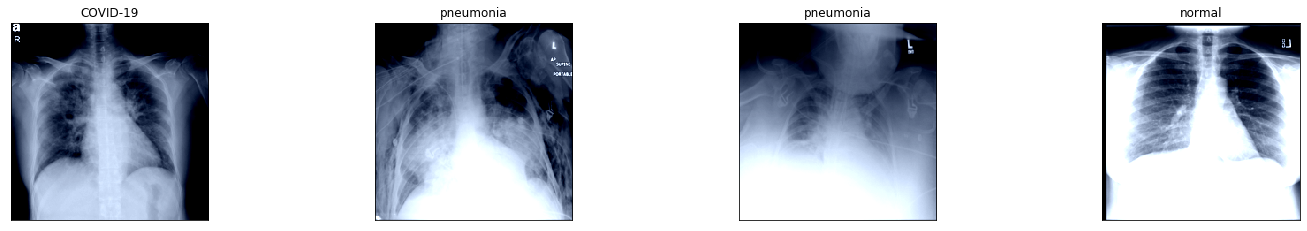

In [30]:

display_size = 4

# desplegar un grupo de imagenes de ejemplo
# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 8))
for idx in np.arange(display_size):
    ax = fig.add_subplot(2, display_size, idx+1, xticks=[], yticks=[])
    image = images[idx]
    image = image.numpy().transpose((1, 2, 0))
    image = (image + np.ones(image.shape))/2
    ax.imshow(image)
    #print(labels[idx])
    #print(labels[idx].numpy())
    idd = labels[idx].numpy()
    num = idd.tolist()
    if(num==2):
        found = True

    #print(num)
    ax.set_title(covidx.id2class[num])

In [ ]:
# create the optimizer

model_ft = model_ft.to(device)

params_to_update = model_ft.parameters()
print("Params to learn")

if feature_extract:
    params_to_update = []
    for name, param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t", name)
else:
    for name, param in model_ft.named_parameters():
        if param.requires_grad == True:
            print("\t", name)
            
optimizer_ft = optim.SGD(params_to_update, lr=0.001, momentum = 0.9)

In [ ]:
criterion = nn.CrossEntropyLoss()

model_ft, hist = train_model(model_ft, dataloaders_dict, criterion, optimizer_ft, num_epochs = num_epochs, is_inception=(model_name=="inception"))



In [ ]:
# store model and weights



In [ ]:
# Test model with some images



In [ ]:
# load the pretrained model

#model_conv = torchvision.models.resnet18(pretrained = True)